In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, Multiply,Average, Subtract
from tensorflow.keras.models import Model
import traffic_data_generator
import traffic_util

Fix the random seeds in numpy, tensorlfow

In [3]:
import random as rn

rand_seed=116
rn.seed(rand_seed)
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)


In [4]:
class Xing_1995 ():
    def __init__(self,delta_t,T1,T2):
        self.alpha=.5
        self.beta=.05
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1=np.max([v.shape[1]-T1_n_steps,0])
        i_T2=np.max([x.shape[1]-T2_n_steps,0])
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        D_n=7+.5*v[1,i_T2]
        return self.alpha*delta_v+self.beta*(delta_x-D_n)

In [5]:
class GHR ():
    def __init__(self, c, m,l,T1,T2):
        self.c=c
        self.m=m
        self.l=l
        self.T1=T1
        self.T2=T2
        
    def acc_func(self,v,delta_x, delta_v):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1=np.max([v.shape[1]-T1_n_steps,0])
        i_T2=np.max([x.shape[1]-T2_n_steps,0])
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        if abs(delta_x)<10**-12:
            delta_x=10**-12
        return v[0,0]**self.m*self.c*delta_v/delta_x**self.l

In [6]:
class Helbing ():
    def __init__(self,V_0,tau,V_e,s,R,tau_prime,T1,T2,delta_t):
        self.V_0=V_0
        self.tau=tau
        self.V_e=V_e
        self.s=s
        self.R=R
        self.tau_prime=tau_prime
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1,i_T2=None,None
        if len(v.shape)==2: i_T1=np.max([v.shape[1]-T1_n_steps-1,0])
        if len(x.shape)==2: i_T2=np.max([x.shape[1]-T2_n_steps-1,0])
        if len(v.shape)==2: v_current=v[1,0]
        else: v_current=v[1]
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        return (self.V_e(delta_x)-v_current)/self.tau-np.exp((delta_x-s(v_current))/-self.R)*(-delta_v/self.tau_prime)*(-delta_v>0)

In [7]:
class Aw ():
    def __init__(self,C,gamma,A,T_r,car_length,V,T1,T2,delta_t):
        self.C=C
        self.gamma=gamma
        self.T_r=T_r
        self.car_length=car_length
        self.V=V
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t    
        self.A=A
        self.max_acc=1
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1,i_T2=None,None
        if len(v.shape)==2: i_T1=np.max([v.shape[1]-T1_n_steps-1,0])
        if len(x.shape)==2: i_T2=np.max([x.shape[1]-T2_n_steps-1,0])
        if len(v.shape)==2: v_current=v[1,0]
        else: v_current=v[1]
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        true_acc= self.C*delta_v/delta_x**(self.gamma+1)+self.A/self.T_r*(self.V(self.car_length/delta_x)-v_current)
#         return np.min([self.max_acc,true_acc])
        return true_acc

In [115]:
def init_loc(separation_mean,separation_var,loc_init,n_cars):
    init_loc_matrix = np.zeros(n_cars)
    if loc_init=='equal_space':
        init_loc_matrix = -np.arange(n_cars)*separation_mean
    elif loc_init=='uniform_separation':
        separation_vector=np.random.uniform(separation_mean-np.sqrt(separation_var*3),separation_mean+np.sqrt(separation_var*3),n_cars-1)
        init_loc_matrix[0] = 0
        for i_car in range(n_cars-1):
            init_loc_matrix[i_car+1] = init_loc_matrix[i_car]-separation_vector[i_car]
    elif loc_init=='uniform':
        min_separation=1/40
        a=np.random.uniform(0,n_cars*separation_mean,n_cars)
        a[0]=0
        init_loc_matrix=-np.sort(a)
        for i_car in range(n_cars-1):
            if init_loc_matrix[i_car]-init_loc_matrix[i_car+1]<min_separation:
                init_loc_matrix[i_car+1]=init_loc_matrix[i_car]-min_separation
    return init_loc_matrix

def init_vel(lead_car_speed,vel_init,vel_init_mean,vel_init_var,n_cars):
    
    init_vel_matrix = np.zeros(n_cars)
    if vel_init=='uniform':
        init_vel_matrix=np.random.uniform(vel_init_mean-np.sqrt(vel_init_var*3),vel_init_mean+np.sqrt(vel_init_var*3),n_cars)
    elif vel_init=='constant':
        init_vel_matrix=np.ones(n_cars)*vel_init_mean
    elif vel_init=='normal':
        init_vel_matrix=np.max([np.zeros(n_cars),np.random.normal(vel_init_mean,vel_init_var,n_cars)],axis=0)
    init_vel_matrix[0]=lead_car_speed
    return init_vel_matrix
    
def move_cars_delta_t(loc_vec,vel_vec,acc_vec,acc_function,delta_t):
    new_vel_vec=np.zeros(vel_vec.shape[0])
    new_loc_vec=np.zeros(loc_vec.shape[0])
    if np.all(acc_vec[1:]==0):
        new_acc_vec=np.zeros(acc_vec.shape[0])
        new_acc_vec[0]=acc_vec[0]
        for i_car in range(1,loc_vec.shape[0]):
            new_acc_vec[i_car] = acc_function(vel_vec[i_car-1:i_car+1],
                                              loc_vec[i_car-1:i_car+1])
    else:
        new_acc_vec=acc_vec
    new_vel_vec = vel_vec + new_acc_vec*delta_t
    new_loc_vec = loc_vec + vel_vec*delta_t + new_acc_vec*delta_t**2/2
    
    return new_loc_vec, new_vel_vec, new_acc_vec
        
def move_cars_delta_max(loc_vec,vel_vec,acc_vec,acc_function,delta_max):
    collision_time_fraction=3
    delta_loc=loc_vec[1:]-loc_vec[:-1]
    delta_vel=vel_vec[1:]-vel_vec[:-1]
    for i_car in range(1,loc_vec.shape[0]):
        acc_vec[i_car] = acc_function(vel_vec[i_car-1:i_car+1],
                                          loc_vec[i_car-1:i_car+1])
    delta_acc=acc_vec[1:]-acc_vec[:-1]
    if np.all(delta_acc!=0): linear_min=delta_gen*collision_time_fraction+1
    elif np.all(delta_vel[delta_acc==0]<=0):linear_min=delta_gen*collision_time_fraction+1
    else:linear_min=np.min(-delta_loc[delta_acc==0 and delta_vel>0]/delta_vel[delta_acc==0 and delta_vel>0])
    real_roots= (delta_vel**2-2*delta_acc*delta_loc) >= 0
    acc_non_zero= (delta_acc!=0)
    dc= np.all([real_roots,acc_non_zero],axis=0) #dc means don't calculate if this is false, we don't calculate it
    first_real_quad_root=(-delta_vel[dc]+np.sqrt(delta_vel[dc]**2-2*delta_acc[dc]*delta_loc[dc]))/delta_acc[dc]
    second_real_quad_root=(-delta_vel[dc]-np.sqrt(delta_vel[dc]**2-2*delta_acc[dc]*delta_loc[dc]))/delta_acc[dc]
    if np.all(first_real_quad_root<=0):first_min=delta_max*collision_time_fraction+1
    else: first_min=np.min(first_real_quad_root[first_real_quad_root>0])
    if np.all(second_real_quad_root<=0):second_min=delta_max*collision_time_fraction+1
    else: second_min=np.min(second_real_quad_root[second_real_quad_root>0])    
    collision_time=np.min([first_min,second_min,linear_min])/collision_time_fraction
    print("ct" + str(collision_time))
    if collision_time<10**-15:
        return "error","error", "error"
    if collision_time >= delta_max:
        return move_cars_delta_t(loc_vec,vel_vec,acc_vec,acc_function,delta_max)
    else:
        delta_max -= collision_time
        print("dm" + str(delta_max))
        loc_vec,vel_vec,acc_vec=move_cars_delta_t(loc_vec,vel_vec,acc_vec,acc_function,collision_time)
        return move_cars_delta_max(loc_vec,vel_vec,acc_vec,acc_function,delta_max)
    
def simulation_1(init_loc_matrix,init_vel_matrix,delta_gen,traj_len,acc_function):
    
    n_cars=init_loc_matrix.shape[0]
    n_t_steps_traj=int(round(traj_len/delta_gen))
    
    loc_matrix = np.zeros([n_cars,n_t_steps_traj])
    loc_matrix[:,0]=init_loc_matrix
    vel_matrix = np.zeros([n_cars,n_t_steps_traj])  
    vel_matrix[:,0]=init_vel_matrix
    acc_matrix = np.zeros([n_cars,n_t_steps_traj])

    time = np.arange(n_t_steps_traj)*delta_gen

    loc_matrix[0,:] = init_vel_matrix[0]*time
    vel_matrix[0,:] = init_vel_matrix[0]+0*time
    acc_matrix[0,:] = 0*time

    for i in range(n_t_steps_traj-1):
        print(i)
        loc_matrix[:,i+1],vel_matrix[:,i+1],acc_matrix[:,i]=move_cars_delta_max(loc_matrix[:,i],vel_matrix[:,i],acc_matrix[:,i],acc_function,delta_gen)

    for i in range(1,n_cars):
        loc_matrix[i,:] -= loc_matrix[0,:]   
    loc_matrix[0,:] -= loc_matrix[0,:]  
    
    return loc_matrix,vel_matrix,acc_matrix


In [66]:
example_name="traffic"
data_dir=traffic_data_generator.set_up(example_name)

In [67]:
delta_gen=0.05
n_traj=25000
n_samples=100000

In [68]:
#===========================
#     Output directories 
#===========================
experiment_name="_no_share"+ \
     "_"+str(n_samples)+"_Delta_"+str(delta_gen)


model_dir=example_name+"/"+experiment_name
plot_dir=model_dir+"/Plots"
checkpoint_dir=model_dir+"/check_points"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [69]:
#ith_run=2 is using true uniform location as opposed to uniform separation

# domain=np.array([#[20,100],#n_cars
#                  [3,10], #tau
#                  [45.,75], #R
#                  [10,80.], #vel_init_mean
#                  [-20,60.], #separation_mean+s(vel_mean)    
# ])

#This is for Aw w/o scaling to 60 ft/sec
domain=np.array([[300,300],#n_cars
                 [5,5], #T_r
                 [1,1], #C
                 [.81,.81], #rho_max
                 [1.3,1.3], #v_max
                 [1.15,1.15], #vel_init_mean
                 [.1,.1], #vel_variance as fraction of meean
                 [.4,.4], #separation_mean
                 [.1,.1], #separation_variance as fraction of meean
                 [20.,20] #traj_length
])


# #This is for Aw w/ scaling to 60 ft/sec
# domain=np.array([#[20,100],#n_cars
#                  [20,20], #T_r
#                  [1,1], #C
#                  [31/100,31/100], #rho_max
#                  [80,80], #v_max
# ])

ith_run=0
new_run=True
while os.path.exists(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy'):
    domain_temp=np.load(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy')
    if np.all(domain==domain_temp):
        new_run=False
        break
    else:
        ith_run+=1
if new_run:
    np.save(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy', domain)
    
domain_key=('n_cars','T_r','C','rho_max','v_max','vel_init_mean','vel_variance as fraction of mean','separation mean',
           'separation variance as a fraction of mean','traj_length')
for i in range(len(domain)):
    print(domain_key[i],domain[i])
print('ith_run',ith_run)

n_cars [300. 300.]
T_r [5. 5.]
C [1. 1.]
rho_max [0.81 0.81]
v_max [1.3 1.3]
vel_init_mean [1.15 1.15]
vel_variance as fraction of mean [0.1 0.1]
separation mean [0.4 0.4]
separation variance as a fraction of mean [0.1 0.1]
traj_length [20. 20.]
ith_run 2


In [70]:
ith_run

2

In [ ]:
# ith_run=??
domain=np.load(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy')
for i in range(len(domain)):
    print(domain_key[i],domain[i])
print('ith_run',ith_run)
traj_len=int(np.random.uniform(domain[9,0],domain[9,1])) # total time 
n_traj_per_run=50
n_runs=int(np.ceil(n_traj/n_traj_per_run))
traj_dir=data_dir+ '/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)
if not os.path.exists(traj_dir):
    os.mkdir(traj_dir) 


for i_run in range(n_runs):
    n_cars=int(np.random.uniform(domain[0,0],domain[0,1])) #int(domain[0,this_combo[0]])
    location=np.zeros([n_traj_per_run,n_cars,int(round(traj_len/delta_gen))])
    velocity=np.zeros([n_traj_per_run,n_cars,int(round(traj_len/delta_gen))])
    if not os.path.exists(traj_dir+ '/velocity'+str(i_run*n_traj_per_run) + ".npy"):
#     if True:
        for i_traj in range(n_traj_per_run): # in range(n_traj_per_run):

            C=np.random.uniform(domain[2,0],domain[2,1])
            gamma=0
            A=1
            T_r=np.random.uniform(domain[1,0],domain[1,1])
            car_length=1/40 
        #     car_length=31
            v_max=np.random.uniform(domain[4,0],domain[4,1])
            def U(rho):return v_max*(np.pi/2.+ np.arctan(11*(rho-.22)/(rho-1)))/(np.pi/2 + np.arctan(11*.22))
            rho_max=np.random.uniform(domain[3,0],domain[3,1])
            def V(rho): return U(rho/rho_max)
            T1=T2=0
            acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).acc_func

            lead_car_speed=1
        #     lead_car_speed=60
            vel_init='uniform'
            #vel_init_mean=domain[2,this_combo[2]]
            vel_init_mean=np.random.uniform(domain[5,0],domain[5,1])
        #     vel_init_mean=60
            vel_init_var=np.random.uniform(domain[6,0],domain[6,1])*vel_init_mean

            init_vel_matrix=init_vel(lead_car_speed,vel_init,vel_init_mean,vel_init_var,n_cars)

        #     separation_mean=s(vel_init_mean)+domain[3,this_combo[3]] # in cars/foot
            separation_mean=np.random.uniform(domain[7,0],domain[7,1])
        #     separation_mean=270
            separation_var=np.random.uniform(domain[8,0],domain[8,1])*abs(separation_mean)
            loc_init='uniform'

            init_loc_matrix= init_loc(separation_mean,separation_var,loc_init,n_cars)

            location[i_traj],velocity[i_traj],acc_matrix=simulation_1(init_loc_matrix,init_vel_matrix,delta_gen,traj_len,acc_function)

        np.save(traj_dir+ '/velocity'+str(i_run*n_traj_per_run) + ".npy",velocity)
        np.save(traj_dir+ '/location'+str(i_run*n_traj_per_run) + ".npy",location)

In [204]:
init_vel_matrix[0]

0.5

In [66]:
.4/3

0.13333333333333333

In [24]:
np.sqrt(3*.4)

1.0954451150103324

In [112]:
domain=np.array([[12,12],#n_cars
                 [5,5], #T_r
                 [1,1], #C
                 [.8,.8], #rho_max
                 [1.3,1.3], #v_max
                 [1.15,1.15], #vel_init_mean
                 [.1,.1], #vel_variance as fraction of meean
                 [1/40,1/40], #separation_mean
                 [0,0], #separation_variance as fraction of meean
                 [100.,100] #traj_length
])

In [113]:

traj_len=int(np.random.uniform(domain[9,0],domain[9,1])) # total time 

n_cars=int(np.random.uniform(domain[0,0],domain[0,1])) #int(domain[0,this_combo[0]])
C=np.random.uniform(domain[2,0],domain[2,1])
gamma=1
A=1
T_r=np.random.uniform(domain[1,0],domain[1,1])
car_length=1/40 
#     car_length=31
v_max=np.random.uniform(domain[4,0],domain[4,1])
def U(rho):return v_max*(np.pi/2.+ np.arctan(11*(rho-.22)/(rho-1)))/(np.pi/2 + np.arctan(11*.22))
rho_max=np.random.uniform(domain[3,0],domain[3,1])
def V(rho): return U(rho/rho_max)
T1=T2=0
acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).acc_func

lead_car_speed=1
#     lead_car_speed=60
vel_init='uniform'
#vel_init_mean=domain[2,this_combo[2]]
vel_init_mean=np.random.uniform(domain[5,0],domain[5,1])
#     vel_init_mean=60
vel_init_var=np.random.uniform(domain[6,0],domain[6,1])*vel_init_mean

init_vel_matrix=init_vel(lead_car_speed,vel_init,vel_init_mean,vel_init_var,n_cars)

#     separation_mean=s(vel_init_mean)+domain[3,this_combo[3]] # in cars/foot
separation_mean=np.random.uniform(domain[7,0],domain[7,1])
#     separation_mean=270
separation_var=np.random.uniform(domain[8,0],domain[8,1])*abs(separation_mean)
loc_init='uniform'

init_loc_matrix= init_loc(separation_mean,separation_var,loc_init,n_cars)

loc_matrix,vel_matrix,acc_matrix=simulation_1(init_loc_matrix,init_vel_matrix,delta_gen,traj_len,acc_function)

0
ct1.897523642005139e-05
dm0.04998102476357995
ct1.5269745253456612e-05
dm0.049965755018326494
ct6.885564949938119e-05
dm0.04989689936882711
ct0.00036110620933547103
dm0.04953579315949164
ct0.00034675091278489
dm0.04918904224670675
ct8.914659945311199e-05
dm0.04909989564725364
ct0.00010223411646561323
dm0.04899766153078802
ct4.895138784900037e-05
dm0.04894871014293902
ct9.548213708598595e-05
dm0.04885322800585303
ct9.892976173843454e-05
dm0.0487542982441146
ct5.90579762395171e-05
dm0.048695240267875084
ct0.00015172762381170292
dm0.04854351264406338
ct8.674399769789891e-05
dm0.048456768646365486
ct0.00011406209040891138
dm0.04834270655595657
ct0.00027957230597659477
dm0.048063134249979975
ct0.00017969444830891925
dm0.047883439801671056
ct0.0001622454682951602
dm0.0477211943333759
ct0.00025419769686193524
dm0.047466996636513964
ct0.00015186830574244876
dm0.04731512833077151
ct0.00026645414941055696
dm0.04704867418136095
ct0.00012772110158400254
dm0.04692095307977695
ct0.0001935082356665

dm0.04300768871019208
ct0.00024229922107062767
dm0.04276538948912145
ct0.00024229948108942822
dm0.042523090008032026
ct0.0002422988911323879
dm0.04228079111689964
ct0.00024229905938077904
dm0.04203849205751886
ct0.00024229857660377138
dm0.04179619348091509
ct0.00024229869800282468
dm0.041553894782912264
ct0.00024229826947153857
dm0.041311596513440726
ct0.00024229836703556533
dm0.04106929814640516
ct0.00024229796567893836
dm0.04082700018072623
ct0.00024229805119036136
dm0.04058470212953587
ct0.0002422976631927103
dm0.04034240446634316
ct0.00024229774267608
dm0.040100106723667074
ct0.00024229736101238507
dm0.03985780936265469
ct0.00024229743754133852
dm0.03961551192511335
ct0.0002422970586627416
dm0.03937321486645061
ct0.00024229713379927604
dm0.03913091773265134
ct0.00024229675593398988
dm0.038888620976717345
ct0.00024229683046638197
dm0.038646324146250965
ct0.0002422964527489372
dm0.03840402769350203
ct0.00024229652707000895
dm0.03816173116643202
ct0.00024229614909523442
dm0.0379194350

ct0.0002583269424187952
dm0.036025797824095734
ct0.0002583270416852725
dm0.03576747078241046
ct0.0002583265782592406
dm0.035509144204151216
ct0.0002583266727888927
dm0.035250817531362326
ct0.00025832621495922964
dm0.0349924913164031
ct0.0002583263070595866
dm0.03473416500934351
ct0.00025832585210062753
dm0.03447583915724288
ct0.00025832594295503573
dm0.03421751321428784
ct0.00025832548946900694
dm0.03395918772481884
ct0.00025832557968430837
dm0.03370086214513453
ct0.0002583251269544051
dm0.033442537018180125
ct0.00025832521684180336
dm0.03318421180133832
ct0.00025832476450043143
dm0.03292588703683789
ct0.00025832485421951683
dm0.03266756218261837
ct0.0002583244020781672
dm0.0324092377805402
ct0.00025832449171078124
dm0.03215091328882942
ct0.00025832403967278246
dm0.03189258924915664
ct0.000258324129260896
dm0.03163426511989574
ct0.00025832367727667265
dm0.03137594144261907
ct0.00025832376684180883
dm0.03111761767577726
ct0.0002583233148859383
dm0.030859294360891323
ct0.0002583234044391

ct0.00026918377943833694
dm0.017485699592968917
ct0.00026918327772717734
dm0.01721651631524174
ct0.0002691833773648227
dm0.016947332937876917
ct0.0002691828756555492
dm0.01667815006222137
ct0.00026918297529280997
dm0.016408967086928558
ct0.00026918247358542313
dm0.016139784613343134
ct0.0002691825732223013
dm0.01587060204012083
ct0.00026918207151680027
dm0.01560141996860403
ct0.0002691821711532954
dm0.015332237797450734
ct0.0002691816694496796
dm0.015063056128001054
ct0.0002691817690857914
dm0.014793874358915262
ct0.00026918126738406146
dm0.014524693091531201
ct0.00026918136701979006
dm0.014255511724511411
ct0.0002691808653199458
dm0.013986330859191466
ct0.0002691809649552911
dm0.013717149894236174
ct0.00026918046325733223
dm0.013447969430978842
ct0.0002691805628922937
dm0.013178788868086547
ct0.0002691800611962211
dm0.012909608806890327
ct0.00026918016083079925
dm0.012640428646059527
ct0.0002691796591366124
dm0.012371248986922915
ct0.0002691797587708077
dm0.012102069228152107
ct0.0002

ct0.00027305117174614087
dm0.012885999539779798
ct0.00027305127514387086
dm0.012612948264635927
ct0.0002730507549303398
dm0.012339897509705587
ct0.0002730508583276634
dm0.012066846651377925
ct0.0002730503381161307
dm0.011793796313261794
ct0.0002730504415130475
dm0.011520745871748747
ct0.0002730499213035137
dm0.011247695950445233
ct0.00027305002470002344
dm0.01097464592574521
ct0.0002730495044924883
dm0.010701596421252721
ct0.00027304960788859063
dm0.01042854681336413
ct0.0002730490876830548
dm0.010155497725681075
ct0.00027304919107875046
dm0.009882448534602324
ct0.0002730486708752134
dm0.009609399863727112
ct0.00027304877427050195
dm0.00933635108945661
ct0.00027304825406896397
dm0.009063302835387647
ct0.0002730483574638457
dm0.0087902544779238
ct0.00027304783726430666
dm0.008517206640659494
ct0.00027304794065878204
dm0.008244158700000712
ct0.0002730474204612411
dm0.007971111279539471
ct0.0002730475238553096
dm0.007698063755684161
ct0.00027304700365976753
dm0.007425016752024394
ct0.0002

ct0.0002856408186934308
dm0.028538621646753824
ct0.00028564023539880444
dm0.02825298141135502
ct0.00028564035164231513
dm0.027967341059712703
ct0.00028563976835102416
dm0.02768170129136168
ct0.0002856398845936039
dm0.027396061406768077
ct0.0002856393013052183
dm0.02711042210546286
ct0.00028563941754704633
dm0.026824782687915813
ct0.0002856388342613501
dm0.026539143853654464
ct0.00028563895050251226
dm0.026253504903151953
ct0.0002856383672194004
dm0.02596786653593255
ct0.00028563848345993084
dm0.02568222805247262
ct0.0002856379001793558
dm0.025396590152293265
ct0.00028563801641925545
dm0.02511095213587401
ct0.00028563743314120795
dm0.0248253147027328
ct0.0002856375493804665
dm0.024539677153352334
ct0.000285636966104951
dm0.024254040187247382
ct0.0002856370823435441
dm0.02396840310490384
ct0.0002856364990705784
dm0.02368276660583326
ct0.00028563661530847396
dm0.023397129990524786
ct0.00028563603203808397
dm0.023111493958486704
ct0.00028563614827523755
dm0.022825857810211465
ct0.000285635

ct0.0002956976036009441
dm0.046300108053272976
ct0.00029547515789345787
dm0.04600463289537952
ct0.00029571993509210467
dm0.04570891296028741
ct0.0002956039947507927
dm0.045413308965536615
ct0.0002957294460439089
dm0.045117579519492704
ct0.0002956666792769071
dm0.0448219128402158
ct0.0002957333492455213
dm0.04452617949097028
ct0.0002956968204585306
dm0.044230482670511745
ct0.00029573495057437076
dm0.04393474771993738
ct0.0002957113318376374
dm0.04363903638809974
ct0.0002957357098263711
dm0.04334330067827337
ct0.0002957185214591136
dm0.04304758215681426
ct0.0002957362433036126
dm0.042751845913510646
ct0.00029572239556509896
dm0.042456123517945546
ct0.00029573680159754914
dm0.042160386716347996
ct0.0002957248515084451
dm0.04186466186483955
ct0.00029573748459110386
dm0.04156892438024845
ct0.00029572677131009306
dm0.041273197608938356
ct0.00029573833349534433
dm0.04097745927544301
ct0.00029572855668608193
dm0.04068173071875693
ct0.0002957393673468749
dm0.04038599135141005
ct0.00029573038582

ct0.00031355252713636064
dm0.014866515401548232
ct0.00031355114110910104
dm0.014552964260439132
ct0.00031355182031982706
dm0.014239412440119305
ct0.0003135504587844975
dm0.013925861981334808
ct0.0003135511142336772
dm0.013612310867101131
ct0.0003135497770727433
dm0.013298761090028388
ct0.0003135504096933151
dm0.012985210680335074
ct0.0003135490966191866
dm0.012671661583715887
ct0.00031354970733830847
dm0.012358111876377578
ct0.00031354841792932117
dm0.012044563458448256
ct0.00031354900766207295
dm0.011731014450786184
ct0.0003135477413924478
dm0.011417466709393736
ct0.0003135483110369032
dm0.011103918398356833
ct0.0003135470673016033
dm0.01079037133105523
ct0.00031354761773501094
dm0.010476823713320219
ct0.0003135463958703262
dm0.010163277317449893
ct0.00031354692794622447
dm0.009849730389503668
ct0.0003135457272467771
dm0.009536184662256891
ct0.0003135462417928982
dm0.009222638420463993
ct0.000313545061525579
dm0.008909093358938415
ct0.00031354555934235453
dm0.008595547799596061
ct0.00

dm0.03079677901001505
ct0.00033805217823999826
dm0.030458726831775054
ct0.00033806143662959334
dm0.03012066539514546
ct0.00033805406770966417
dm0.029782611327435794
ct0.00033806319329796286
dm0.02944454813413783
ct0.0003380553776997036
dm0.029106492756438125
ct0.00033806434107869747
dm0.028768428415359426
ct0.00033805622420822766
dm0.028430372191151198
ct0.0003380650038875642
dm0.028092307187263632
ct0.0003380567013074546
dm0.02775425048595618
ct0.0003380652823065152
dm0.027416185203649662
ct0.00033805688523346595
dm0.027078128318416196
ct0.00033806525781560006
dm0.026740063060600595
ct0.00033805683771739105
dm0.026402006222883204
ct0.00033806499630543773
dm0.026063941226577767
ct0.00033805660869324055
dm0.025725884617884526
ct0.000338064550966547
dm0.02538782006691798
ct0.0003380562384975353
dm0.025049763828420446
ct0.0003380639646535694
dm0.024711699863766878
ct0.0003380557596564243
dm0.024373644104110453
ct0.0003380632718141168
dm0.024035580832296337
ct0.0003380551983386
dm0.0236975

dm0.022534927767824564
ct0.00036127158153705015
dm0.022173656186287513
ct0.0003612718089331521
dm0.02181238437735436
ct0.0003612707122916015
dm0.02145111366506276
ct0.00036127093773547604
dm0.021089842727327283
ct0.000361269846634858
dm0.020728572880692426
ct0.00036127007041984223
dm0.020367302810272582
ct0.0003612689840280019
dm0.02000603382624458
ct0.00036126920640333
dm0.01964476461984125
ct0.00036126812401322947
dm0.01928349649582802
ct0.0003612683451906682
dm0.018922228150637353
ct0.00036126726620157925
dm0.018560960884435772
ct0.00036126748636104516
dm0.01819969339807473
ct0.00036126641026256763
dm0.017838426987812163
ct0.0003612666295569218
dm0.01747716035825524
ct0.00036126555591540566
dm0.017115894802339833
ct0.00036126577447453126
dm0.0167546290278653
ct0.00036126470292152847
dm0.01639336432494377
ct0.0003612649208557677
dm0.016032099404088004
ct0.00036126385107823064
dm0.015670835553009774
ct0.00036126406848134004
dm0.015309571484528434
ct0.00036126300021328833
dm0.014948308

ct0.00037479943775116283
dm0.02224146383117907
ct0.000374799673819419
dm0.02186666415735965
ct0.00037479850997425675
dm0.021491865647385394
ct0.00037479874604099615
dm0.0211170669013444
ct0.00037479758220311846
dm0.02074226931914128
ct0.00037479781826833786
dm0.020367471500872942
ct0.00037479665443774856
dm0.019992674846435195
ct0.0003747968905014612
dm0.019617877955933734
ct0.0003747957266781499
dm0.019243082229255585
ct0.00037479596274034337
dm0.018868286266515242
ct0.00037479479892431425
dm0.01849349146759093
ct0.000374795034984991
dm0.018118696432605937
ct0.0003747938711762438
dm0.017743902561429693
ct0.00037479410723539403
dm0.017369108454194298
ct0.000374792943433939
dm0.01699431551076036
ct0.000374793179491579
dm0.01661952233126878
ct0.0003747920156974047
dm0.016244730315571377
ct0.00037479225175352323
dm0.015869938063817854
ct0.0003747910879666376
dm0.015495146975851217
ct0.00037479132402123456
dm0.015120355651829983
ct0.0003747901602416342
dm0.014745565491588349
ct0.0003747903

ct0.00038843724114039297
dm0.017031037064422123
ct0.0003884359663374891
dm0.016642601098084634
ct0.00038843622556905853
dm0.016254164872515575
ct0.00038843495077455864
dm0.015865729921741015
ct0.00038843521000439155
dm0.015477294711736624
ct0.0003884339352183017
dm0.015088860776518323
ct0.00038843419444637843
dm0.014700426582071944
ct0.00038843291966870786
dm0.014311993662403235
ct0.00038843317889500996
dm0.013923560483508225
ct0.0003884319041257799
dm0.013535128579382445
ct0.0003884321633503263
dm0.01314669641603212
ct0.00038843088858952433
dm0.012758265527442596
ct0.00038843114781230586
dm0.01236983437963029
ct0.00038842987305994083
dm0.01198140450657035
ct0.00038843013228095897
dm0.01159297437428939
ct0.00038842885753702713
dm0.011204545516752363
ct0.0003884291167562801
dm0.010816116399996082
ct0.0003884278420207829
dm0.010427688557975299
ct0.00038842810123826806
dm0.010039260456737031
ct0.0003884268265112057
dm0.009650833630225826
ct0.0003884270857269243
dm0.009262406544498902
ct0.

ct0.0004047530389031237
dm0.01513360088948934
ct0.0004047516231286532
dm0.014728849266360687
ct0.0004047519118920299
dm0.014324097354468657
ct0.0004047504961275338
dm0.013919346858341123
ct0.0004047507848888118
dm0.01351459607345231
ct0.00040474936913429776
dm0.013109846704318013
ct0.00040474965789347953
dm0.012705097046424533
ct0.0004047482421489527
dm0.01230034880427558
ct0.00040474853090604967
dm0.01189560027336953
ct0.0004047471151715003
dm0.01149085315819803
ct0.0004047474039265036
dm0.011086105754271526
ct0.00040474598820192917
dm0.010681359766069596
ct0.0004047462769548365
dm0.01027661348911476
ct0.00040474486124024374
dm0.009871868627874515
ct0.000404745149991049
dm0.009467123477883466
ct0.00040474373428644534
dm0.009062379743597021
ct0.00040474402303514553
dm0.008657635720561876
ct0.0004047426073405318
dm0.008252893113221344
ct0.00040474289608713297
dm0.007848150217134212
ct0.00040474148040250583
dm0.0074434087367317055
ct0.0004047417691470161
dm0.007038666967584689
ct0.000404

ct0.000430882759850952
dm0.04221908554848111
ct0.0004304801638984029
dm0.041788605384582705
ct0.00043077001069202845
dm0.04135783537389068
ct0.0004143980942604823
dm0.04094343727963019
ct0.0004437059805618646
dm0.04049973129906833
ct0.00038933306080083177
dm0.040110398238267495
ct0.0004777773602576683
dm0.039632620878009825
ct0.00040337210709488535
dm0.03922924877091494
ct0.00048822655581046533
dm0.03874102221510447
ct0.0004449096784148632
dm0.0382961125366896
ct0.0004980071891822626
dm0.03779810534750734
ct0.00047166990852956573
dm0.037326435438977776
ct0.0005013773661610884
dm0.036825058072816684
ct0.0004890763488534863
dm0.0363359817239632
ct0.0004877735738340865
dm0.03584820815012911
ct0.0005064233306517225
dm0.03534178481947739
ct0.00047920542252758314
dm0.034862579396949804
ct0.0005047390544367598
dm0.034357840342513046
ct0.0004742374229710024
dm0.033883602919542045
ct0.0004940011984197686
dm0.03338960172112228
ct0.00047152466256857
dm0.03291807705855371
ct0.0004832569883426716
d

ct0.0004915344138163853
dm0.04604256036061413
ct0.00048340696655905607
dm0.04555915339405508
ct0.0004938254286297127
dm0.04506532796542537
ct0.0004850167692070794
dm0.04458031119621829
ct0.0004951039918904876
dm0.0440852072043278
ct0.0004864188939677713
dm0.04359878831036003
ct0.0004955502722555422
dm0.04310323803810449
ct0.00048756775747557955
dm0.04261567028062891
ct0.000495335566202356
dm0.042120334714426555
ct0.0004884405851293019
dm0.041631894129297256
ct0.0004946288269842967
dm0.04113726530231296
ct0.0004890395519567
dm0.04064822575035626
ct0.0004935964976898201
dm0.04015462925266644
ct0.0004893883186917277
dm0.039665240933974714
ct0.00049239322484141
dm0.039172847709133304
ct0.000489525246058177
dm0.038683322463075126
ct0.000491153126867653
dm0.03819216933620747
ct0.0004894964701759875
dm0.03770267286603148
ct0.0004899826889520778
dm0.037212690177079406
ct0.000489349657157806
dm0.0367233405199216
ct0.000488957233932775
dm0.036234383285988825
ct0.000489129206767734
dm0.0357452540

ct0.0004945793727813322
dm0.00789927267153965
ct0.0004945338508815987
dm0.007404738820658052
ct0.0004945933884743823
dm0.006910145432183669
ct0.0004945415064670288
dm0.00641560392571664
ct0.0004946028121783612
dm0.005921001113538279
ct0.0004945486338552614
dm0.005426452479683017
ct0.00049460787004511
dm0.004931844609637907
ct0.000494554819156017
dm0.0044372897904818905
ct0.0004946090023540178
dm0.0039426807881278725
ct0.0004945597829792112
dm0.003448121005148661
ct0.00049460679705054
dm0.002953514208098121
ct0.0004945633713740034
dm0.0024589508367241176
ct0.0004946019271680904
dm0.001964348909556027
ct0.0004945655410728817
dm0.0014697833684831456
ct0.0004945950950380285
dm0.0009751882734451171
ct0.0004945663409847293
dm0.00048062193246038785
ct0.0004945869852814525
29
ct0.000505453489570277
dm0.04949454651042973
ct0.0005000132344513817
dm0.048994533275978344
ct0.0004926631677455252
dm0.04850187010823282
ct0.0004926624023446163
dm0.04800920770588821
ct0.0004919891458509538
dm0.047517218

ct0.000495691456630206
dm0.0028536442179223796
ct0.0004955718863424795
dm0.0023580723315799
ct0.0004956722462312572
dm0.0018624000853486428
ct0.0004955580710406688
dm0.0013668420143079741
ct0.0004956550065180063
dm0.0008711870077899678
ct0.0004955518168262288
dm0.000375635190963739
ct0.0004956402649420822
32
ct0.0006345435108683507
dm0.049365456489131654
ct0.0005398039928035864
dm0.048825652496328066
ct0.0004929392214695724
dm0.048332713274858496
ct0.0005135760056993003
dm0.0478191372691592
ct0.0005163411079021946
dm0.047302796161257
ct0.0005177131749420028
dm0.046785082986315
ct0.0004965981577685463
dm0.04628848482854645
ct0.0005118994938996156
dm0.04577658533464683
ct0.0004897818603402371
dm0.045286803474306594
ct0.0005082846253972027
dm0.04477851884890939
ct0.00048284393095392
dm0.04429567491795547
ct0.0005044413658446251
dm0.04379123355211084
ct0.00047960210877225393
dm0.04331163144333859
ct0.0005013609537780527
dm0.042810270489560535
ct0.0004785400383417494
dm0.04233173045121879
c

ct0.0004990990518516343
dm0.036787773013370675
ct0.0005109138426211366
dm0.03627685917074954
ct0.0005015982144317622
dm0.03577526095631778
ct0.0005101878250343432
dm0.035265073131283436
ct0.0005041278363296384
dm0.0347609452949538
ct0.0005098273069855964
dm0.034251117987968205
ct0.0005066332620497414
dm0.03374448472591846
ct0.0005097968395091785
dm0.033234687886409285
ct0.0005090862277440186
dm0.03272560165866527
ct0.0005100589206404818
dm0.03221554273802479
ct0.000511470771652854
dm0.031704071966371934
ct0.0005105750334848115
dm0.031193496932887123
ct0.0005137752511791168
dm0.030679721681708006
ct0.0005113066203782896
dm0.030168415061329716
ct0.0005159881116652913
dm0.029652426949664426
ct0.0005122157309473023
dm0.029140211218717123
ct0.0005180960071833716
dm0.028622115211533752
ct0.0005132653971760718
dm0.02810884981435768
ct0.0005200832582426539
dm0.027588766556115026
ct0.000514419822799007
dm0.027074346733316018
ct0.0005219320551111073
dm0.026552414678204912
ct0.0005156444819507467

ct0.00048628483424723116
dm0.04262021468234523
ct0.0005158241555946845
dm0.04210439052675055
ct0.0004762211931794084
dm0.04162816933357114
ct0.0005032498152049717
dm0.04112491951836617
ct0.00046841042771173885
dm0.040656509090654436
ct0.00048387297698220064
dm0.040172636113672236
ct0.0004662699026390515
dm0.039706366211033184
ct0.00047344003273898995
dm0.03923292617829419
ct0.00046490171221090417
dm0.03876802446608329
ct0.00046850718748940866
dm0.03829951727859388
ct0.00046423743827618205
dm0.0378352798403177
ct0.0004660583065184475
dm0.03736922153379925
ct0.00046389771619920347
dm0.03690532381760005
ct0.0004648258741734425
dm0.0364404979434266
ct0.00046372280712500373
dm0.0359767751363016
ct0.00046419788717402176
dm0.035512577249127576
ct0.0004636312717420107
dm0.035048945977385566
ct0.0004638752766115242
dm0.034585070700774045
ct0.00046358243926945684
dm0.03412148826150459
ct0.000463708207703815
dm0.033657780053800775
ct0.00046355563451514766
dm0.03319422441928563
ct0.000463620780776

ct0.0006169333010336656
dm0.045335215946605
ct0.0006248099956523731
dm0.04471040595095263
ct0.0006156534024830176
dm0.04409475254846961
ct0.0006237467034040607
dm0.04347100584506555
ct0.0006144789185390579
dm0.04285652692652649
ct0.0006225289383198064
dm0.042233997988206685
ct0.0006134034029768073
dm0.041620594585229875
ct0.0006213306832773656
dm0.04099926390195251
ct0.0006122715229992755
dm0.04038699237895323
ct0.0006201275243459644
dm0.039766864854607266
ct0.0006111394427196783
dm0.03915572541188759
ct0.0006189293474917086
dm0.03853679606439588
ct0.0006099946201051956
dm0.037926801444290684
ct0.000617732064224901
dm0.037309069380065785
ct0.0006088386353063062
dm0.03670023074475948
ct0.000616534675148778
dm0.0360836960696107
ct0.0006076688958598016
dm0.035476027173750896
ct0.000615335299678229
dm0.03486069187407267
ct0.0006064837686851149
dm0.034254208105387554
ct0.0006141322298399681
dm0.033640075875547584
ct0.0006052812090025364
dm0.03303479466654505
ct0.0006129236346781838
dm0.0324

ct0.0005394877569123462
dm0.03738217034991612
ct0.000539684978245063
dm0.03684248537167106
ct0.0005395958635623709
dm0.03630288950810869
ct0.0005396955079991676
dm0.03576319400010952
ct0.0005396489204377053
dm0.03522354507967182
ct0.0005396988016568242
dm0.034683846278015
ct0.0005396739182651351
dm0.03414417235974986
ct0.0005396985341850239
dm0.03360447382556484
ct0.0005396846916262363
dm0.03306478913393861
ct0.0005396965629105873
dm0.03252509257102802
ct0.0005396883116536727
dm0.03198540425937435
ct0.0005396938171292661
dm0.03144571044224508
ct0.0005396883802227596
dm0.030906022062022323
ct0.0005396907544371819
dm0.03036633130758514
ct0.0005396867231310702
dm0.02982664458445407
ct0.0005396875941961074
dm0.029286956990257965
ct0.0005396842589467284
dm0.028747272731311238
ct0.000539684436622332
dm0.028207588294688907
ct0.0005396814442529286
dm0.027667906850435978
ct0.0005396813232849137
dm0.027128225527151065
ct0.0005396785014769836
dm0.02658854702567408
ct0.0005396782676497135
dm0.0260

ct0.0004972289522170271
dm0.013283068781465087
ct0.0004972675725892174
dm0.012785801208875871
ct0.0004972295900243565
dm0.012288571618851515
ct0.0004972289786297815
dm0.011791342640221733
ct0.0004972357160021595
dm0.011294106924219574
ct0.0004972170308708281
dm0.010796889893348746
ct0.0004972427980978823
dm0.010299647095250863
ct0.0004972196682266505
dm0.009802427427024212
ct0.0004972484462724402
dm0.009305178980751772
ct0.0004972283158979012
dm0.008807950664853872
ct0.0004972517724222986
dm0.008310698892431573
ct0.0004972376606307042
dm0.00781346123180087
ct0.0004972528009300637
dm0.0073162084308708054
ct0.0004972449709538877
dm0.006818963459916918
ct0.0004972520083356382
dm0.00632171145158128
ct0.0004972493003399553
dm0.005824462151241325
ct0.0004972500097428444
dm0.005327212141498481
ct0.0004972507684555997
dm0.004829961373042881
ct0.0004972473752287295
dm0.004332713997814152
ct0.000497250007812165
dm0.003835463990001987
ct0.000497244544874907
dm0.00333821944512708
ct0.0004972477919

ct0.00048503343863348126
dm0.011621072449175979
ct0.00048503119827871406
dm0.011136041250897266
ct0.00048503166192272705
dm0.010651009588974539
ct0.0004850294215888805
dm0.010165980167385659
ct0.0004850298852283918
dm0.009680950282157267
ct0.0004850276449155383
dm0.009195922637241729
ct0.00048502810855053003
dm0.008710894528691199
ct0.00048502586825867826
dm0.00822586866043252
ct0.0004850263318892045
dm0.007740842328543315
ct0.00048502409161832157
dm0.007255818236924994
ct0.0004850245552443661
dm0.006770793681680628
ct0.00048502231499446047
dm0.006285771366686168
ct0.000485022778615967
dm0.005800748588070202
ct0.0004850205383870746
dm0.005315728049683127
ct0.00048502100200412465
dm0.004830707047679002
ct0.00048501876179619534
dm0.004345688285882807
ct0.0004850192254087702
dm0.003860669060474037
ct0.0004850169852218072
dm0.0033756520752522296
ct0.00048501744882992534
dm0.0028906346264223042
ct0.0004850152086639169
dm0.0024056194177583872
ct0.0004850156722675882
dm0.001920603745490799
ct

ct0.0004861273142956957
dm0.020829269430349996
ct0.00048612506100360577
dm0.02034314436934639
ct0.0004861255274116213
dm0.01985701884193477
ct0.0004861232741396575
dm0.019370895567795112
ct0.00048612374054360624
dm0.018884771827251505
ct0.00048612148729226015
dm0.018398650339959244
ct0.0004861219536919066
dm0.017912528386267338
ct0.0004861197004614731
dm0.017426408685805864
ct0.0004861201668567465
dm0.016940288518949118
ct0.00048611791364731324
dm0.016454170605301806
ct0.00048611838003809177
dm0.015968052225263714
ct0.00048611612684977085
dm0.015481936098413944
ct0.00048611659323607586
dm0.014995819505177867
ct0.00048611434006888505
dm0.014509705165108982
ct0.00048611480645069377
dm0.014023590358658288
ct0.00048611255330464074
dm0.013537477805353648
ct0.00048611301968193445
dm0.013051364785671713
ct0.0004861107665570422
dm0.012565254019114671
ct0.0004861112329298144
dm0.012079142786184856
ct0.000486108979826074
dm0.011593033806358783
ct0.00048610944619430473
dm0.011106924360164479
ct0.

ct0.0005007257078629804
dm0.04528655511642432
ct0.0005163244008509639
dm0.04477023071557336
ct0.000509204209474213
dm0.044261026506099144
ct0.0005176006449490305
dm0.04374342586115011
ct0.0005138549910802088
dm0.0432295708700699
ct0.0005182729493211115
dm0.04271129792074879
ct0.0005163261867701274
dm0.04219497173397867
ct0.0005186221463994722
dm0.041676349587579195
ct0.0005176170428556085
dm0.04115873254472359
ct0.0005188017880690089
dm0.04063993075665458
ct0.000518284743978842
dm0.04012164601267573
ct0.0005188933292226094
dm0.039602752683453125
ct0.00051862795186972
dm0.0390841247315834
ct0.0005189393676377292
dm0.038565185363945674
ct0.0005188034158610846
dm0.03804638194808459
ct0.0005189619822879833
dm0.0375274199657966
ct0.000518892499149065
dm0.03700852746664754
ct0.0005189725607100419
dm0.0364895549059375
ct0.0005189371894438733
dm0.035970617716493625
ct0.000518976960294304
dm0.03545164075619932
ct0.0005189590889482619
dm0.03493268166725105
ct0.0005189781895540184
dm0.03441370347

ct0.0005759178611977521
dm0.023928141800872976
ct0.0005667116540665961
dm0.02336143014680638
ct0.0005800544679146993
dm0.02278137567889168
ct0.00056931427797575
dm0.022212061400915927
ct0.0005839322403067214
dm0.021628129160609206
ct0.0005718645287532824
dm0.021056264631855923
ct0.000588164448238046
dm0.020468100183617877
ct0.0005746423392900044
dm0.01989345784432787
ct0.0005925583971683103
dm0.019300899447159563
ct0.0005776395105443999
dm0.018723259936615163
ct0.0005969981837892833
dm0.01812626175282588
ct0.0005808346796755039
dm0.017545427073150377
ct0.0005619072582838826
dm0.016983519814866493
ct0.0005711075881542702
dm0.016412412226712223
ct0.0005534342617327625
dm0.01585897796497946
ct0.0005719625841617417
dm0.015287015380817719
ct0.0005572544103858936
dm0.014729760970431825
ct0.0005767969793405687
dm0.014152963991091257
ct0.0005608018949573578
dm0.013592162096133899
ct0.0005822571939872206
dm0.013009904902146678
ct0.0005645760981423488
dm0.012445328804004329
ct0.00058821599849182

ct0.0005572398001651434
dm0.02831502405120565
ct0.0005572368185915455
dm0.027757787232614104
ct0.0005572373949991879
dm0.027200549837614916
ct0.0005572343091742676
dm0.02664331552844065
ct0.0005572349308509095
dm0.02608608059758974
ct0.0005572317915821596
dm0.02552884880600758
ct0.0005572324364695986
dm0.024971616369537982
ct0.0005572292698119944
dm0.024414387099725987
ct0.0005572299265983633
dm0.023857157173127624
ct0.0005572267459133956
dm0.02329993042721423
ct0.0005572274087977941
dm0.022742703018416435
ct0.0005572242209374506
dm0.022185478797478984
ct0.000557224886945068
dm0.021628253910533916
ct0.0005572216954231821
dm0.021071032215110735
ct0.0005572223630285311
dm0.020513809852082204
ct0.0005572191696470138
dm0.01995659068243519
ct0.0005572198380677926
dm0.019399370844367398
ct0.000557216643750699
dm0.0188421542006167
ct0.0005572173125856695
dm0.018284936888031032
ct0.0005572141178068969
dm0.017727722770224136
ct0.0005572147868503682
dm0.017170507983373766
ct0.0005572115918529274

ct0.0005826543848871001
dm0.01836853173946365
ct0.0005826551382045912
dm0.01778587660125906
ct0.0005826515557846396
dm0.01720322504547442
ct0.0005826523091765641
dm0.016620572736297853
ct0.0005826487267018063
dm0.016037924009596045
ct0.0005826494801271149
dm0.01545527452946893
ct0.000582645897646012
dm0.014872628631822917
ct0.0005826466510837652
dm0.014289981980739152
ct0.0005826430686211064
dm0.013707338912118045
ct0.0005826438220605081
dm0.013124695090057537
ct0.0005826402396290145
dm0.012542054850428521
ct0.0005826409930645435
dm0.011959413857363977
ct0.0005826374106707353
dm0.011376776446693241
ct0.0005826381640995201
dm0.010794138282593721
ct0.0005826345817467797
dm0.010211503700846941
ct0.0005826353351673344
dm0.009628868365679607
ct0.0005826317528574153
dm0.009046236612822191
ct0.0005826325062690734
dm0.008463604106553118
ct0.0005826289240027968
dm0.007880975182550322
ct0.0005826296774051449
dm0.007298345505145177
ct0.0005826260951829729
dm0.006715719409962204
ct0.00058262684857

ct0.0006171854329913769
dm0.03303449262710558
ct0.0006176477029753914
dm0.03241684492413019
ct0.0006172302542880056
dm0.031799614669842186
ct0.0006176706228826841
dm0.031181944046959502
ct0.0006172728649252534
dm0.030564671182034247
ct0.0006176925929598594
dm0.02994697858907439
ct0.0006173133762667491
dm0.02932966521280764
ct0.0006177136200672899
dm0.02871195159274035
ct0.000617351896617288
dm0.02809459969612306
ct0.0006177337261901217
dm0.02747686596993294
ct0.0006173885293793794
dm0.02685947744055356
ct0.0006177529400377212
dm0.026241724500515838
ct0.0006174233724092619
dm0.025624301128106576
ct0.0006177712929459244
dm0.025006529835160652
ct0.0006174565179355701
dm0.02438907331722508
ct0.0006177888168841951
dm0.023771284500340883
ct0.0006174880527324187
dm0.023153796447608465
ct0.00061780554349481
dm0.022535990904113654
ct0.000617518058399458
dm0.021918472845714198
ct0.0006178215036398409
dm0.02130065134207436
ct0.0006175466116776404
dm0.02068310473039672
ct0.00061783672719738
dm0.02

ct0.0005804431350762339
dm0.002031187025778748
ct0.0005804484749522071
dm0.0014507385508265407
ct0.0005804742687910042
dm0.0008702642820355365
ct0.0005804440192347333
dm0.00028982026280080313
ct0.0005804650224772448
74
ct0.0132337082740354
dm0.0367662917259646
ct0.0021059564443961618
dm0.034660335281568436
ct0.0008952861050791241
dm0.033765049176489315
ct0.0006569215932247388
dm0.03310812758326458
ct0.0006067757110623152
dm0.03250135187220226
ct0.0005965026310146425
dm0.03190484924118762
ct0.0006050385485454989
dm0.03129981069264212
ct0.0006042784329669139
dm0.030695532259675206
ct0.0005961060452155399
dm0.030099426214459667
ct0.0006098990792396713
dm0.029489527135219996
ct0.0005960295411938442
dm0.028893497594026152
ct0.0006025647308469695
dm0.028290932863179182
ct0.0006073792676989822
dm0.0276835535954802
ct0.0006000088821820824
dm0.027083544713298116
ct0.0006082199070687247
dm0.02647532480622939
ct0.0006046336480140534
dm0.025870691158215338
ct0.00060153858600813
dm0.025269152572207

ct0.000669601416083136
dm0.03614644783289012
ct0.0006526099258407007
dm0.03549383790704942
ct0.000667224553085529
dm0.03482661335396389
ct0.0006495021065635669
dm0.034177111247400326
ct0.0006647148447137251
dm0.0335123964026866
ct0.0006461248709082766
dm0.032866271531778325
ct0.0006620491271683787
dm0.03220422240460995
ct0.0006424307897872367
dm0.03156179161482271
ct0.0006591988567970734
dm0.03090259275802564
ct0.0006383564630358276
dm0.03026423629498981
ct0.0006561279419103868
dm0.029608108353079424
ct0.0006338236776962528
dm0.028974284675383172
ct0.0006527917738395279
dm0.028321492901543645
ct0.0006287320432600277
dm0.027692760858283618
ct0.0006400997259191086
dm0.02705266113236451
ct0.0006285494016745259
dm0.026424111730689984
ct0.0006223091378428611
dm0.025801802592847124
ct0.0006312196892022717
dm0.025170582903644854
ct0.0006210710199550672
dm0.024549511883689788
ct0.0006270128150142679
dm0.02392249906867552
ct0.0006285195518453229
dm0.023293979516830196
ct0.000624995563111019
dm0

dm0.028670591699242156
ct0.0007331336525123658
dm0.02793745804672979
ct0.0007373843596258192
dm0.02720007368710397
ct0.0007306843976278486
dm0.02646938928947612
ct0.0007363102003362273
dm0.025733079089139892
ct0.0007296811714516423
dm0.02500339791768825
ct0.0007354695308909148
dm0.024267928386797335
ct0.0007290576500554464
dm0.02353887073674189
ct0.0007346864250852943
dm0.022804184311656595
ct0.0007283974871071115
dm0.022075786824549484
ct0.0007339004026556019
dm0.021341886421893882
ct0.0007277398071492795
dm0.020614146614744602
ct0.000733126843218187
dm0.019881019771526415
ct0.0007270900645947258
dm0.01915392970693169
ct0.000732366410124645
dm0.018421563296807046
ct0.0007264442947829269
dm0.01769511900202412
ct0.0007316174965076898
dm0.01696350150551643
ct0.0007258028450421455
dm0.016237698660474285
ct0.0007308795064857784
dm0.015506819153988506
ct0.0007251653109645596
dm0.014781653843023946
ct0.0007301516841778523
dm0.014051502158846095
ct0.0007245310898470631
dm0.013326971068999032


ct0.0006434752073286025
dm0.024980702870019824
ct0.0006434711474343236
dm0.0243372317225855
ct0.0006434718811080148
dm0.023693759841477483
ct0.0006434675391774025
dm0.02305029230230008
ct0.0006434683955337163
dm0.022406823906766366
ct0.0006434639096971215
dm0.021763359997069246
ct0.0006434648287151671
dm0.02111989516835408
ct0.0006434602696487479
dm0.020476434898705334
ct0.0006434612206051702
dm0.019832973678100163
ct0.0006434566244297702
dm0.019189517053670394
ct0.0006434575916123884
dm0.018546059462058007
ct0.0006434529767567538
dm0.017902606485301252
ct0.0006434539521415449
dm0.017259152533159707
ct0.0006434493279831997
dm0.016615703205176507
ct0.0006434503074808977
dm0.015972252897695608
ct0.0006434456787727349
dm0.015328807218922873
ct0.0006434466603060496
dm0.014685360558616823
ct0.0006434420294422384
dm0.014041918529174585
ct0.0006434430119612752
dm0.01339847551721331
ct0.0006434383801362198
dm0.012755037137077091
ct0.0006434393631142198
dm0.012111597773962871
ct0.00064343473091

ct0.00074271396483099
dm0.0121030155554194
ct0.0007817624051068794
dm0.011321253150312521
ct0.0007493510715544473
dm0.010571902078758074
ct0.0007901021110877002
dm0.009781799967670373
ct0.0007562212461693817
dm0.009025578721500992
ct0.0007983603578300817
dm0.00822721836367091
ct0.0007632593744901533
dm0.007463958989180758
ct0.0008064401343550869
dm0.006657518854825671
ct0.0007703959607475646
dm0.005887122894078106
ct0.0008142540559000298
dm0.005072868838178076
ct0.0007775603026551181
dm0.004295308535522958
ct0.0008217280008747744
dm0.0034735805346481833
ct0.000784683628052272
dm0.0026888969065959113
ct0.0008288034330129266
dm0.0018600934735829846
ct0.0007917018896860518
dm0.0010683915838969327
ct0.0008354383365051401
dm0.00023295324739179253
ct0.0007985579879296305
90
ct0.0011474161402708842
dm0.04885258385972912
ct0.0009264485740869063
dm0.04792613528564221
ct0.0008288645158944755
dm0.047097270769747734
ct0.0008628735774451383
dm0.046234397192302594
ct0.0008306357455720114
dm0.0454037

ct0.000713382169137299
dm0.021356082929274732
ct0.0007133916876673466
dm0.020642691241607385
ct0.0007133765917625364
dm0.019929314649844848
ct0.0007133898265794612
dm0.01921592482326539
ct0.0007133789151679322
dm0.018502545908097457
ct0.0007133878192974526
dm0.017789158088800005
ct0.0007133804895274404
dm0.017075777599272566
ct0.000713387641084741
dm0.016362389958187826
ct0.0007133790451437569
dm0.01564901091304407
ct0.0007133876704352028
dm0.014935623242608866
ct0.0007133776286660174
dm0.014222245613942848
ct0.0007133870327300476
dm0.0135088585812128
ct0.0007133773439814746
dm0.012795481237231326
ct0.0007133862615845642
dm0.012082094975646761
ct0.0007133771434139502
dm0.01136871783223281
ct0.0007133857288565307
dm0.01065533210337628
ct0.0007133765263667378
dm0.009941955577009541
ct0.0007133852659530071
dm0.009228570311056535
ct0.0007133758430191545
dm0.00851519446803738
ct0.000713384719643117
dm0.007801809748394263
ct0.0007133753099421936
dm0.007088434438452069
ct0.0007133841402104276

dm0.028951264522884
ct0.0007241413469539098
dm0.02822712317593009
ct0.0007241312342507403
dm0.02750299194167935
ct0.0007241231794383163
dm0.026778868762241035
ct0.0007241358128438828
dm0.026054732949397152
ct0.0007241158545249435
dm0.025330617094872207
ct0.0007241325116058899
dm0.02460648458326632
ct0.0007241210077991073
dm0.023882363575467212
ct0.0007241298612736645
dm0.02315823371419355
ct0.0007241235234610981
dm0.02243411019073245
ct0.0007241301239870023
dm0.02170998006674545
ct0.0007241212615843968
dm0.020985858805161052
ct0.0007241304499557292
dm0.020261728355205323
ct0.0007241194630244167
dm0.019537608892180907
ct0.0007241297301154142
dm0.018813479162065494
ct0.0007241194376125384
dm0.018089359724452955
ct0.0007241288802762986
dm0.017365230844176658
ct0.00072411942642591
dm0.016641111417750747
ct0.0007241283948759358
dm0.015916983022874812
ct0.0007241187761592491
dm0.015192864246715563
ct0.0007241279937275891
dm0.014468736252987974
ct0.0007241180552804367
dm0.013744618197707536
c

ct0.0007347445038551094
dm0.025010231600965063
ct0.0007347336131456171
dm0.024275497987819448
ct0.0007347433642971043
dm0.023540754623522342
ct0.0007347341546934842
dm0.022806020468828857
ct0.0007347431635271793
dm0.022071277305301677
ct0.000734733097598258
dm0.02133654420770342
ct0.0007347429664507737
dm0.020601801241252646
ct0.0007347322110236521
dm0.019867069030228994
ct0.000734742449401396
dm0.0191323265808276
ct0.0007347318931334602
dm0.01839759468769414
ct0.0007347418877935419
dm0.0176628527999006
ct0.0007347315939034113
dm0.01692812120599719
ct0.0007347414293503884
dm0.0161933797766468
ct0.0007347311030536551
dm0.015458648673593145
ct0.0007347410000330063
dm0.01472390767356014
ct0.0007347305798974868
dm0.013989177093662652
ct0.0007347405394059328
dm0.01325443655425672
ct0.0007347301177506181
dm0.012519706436506102
ct0.0007347400645730064
dm0.011784966371933096
ct0.0007347296748462825
dm0.011050236697086813
ct0.0007347395984765836
dm0.01031549709861023
ct0.000734729213685617
dm0.

ct0.000828754728453897
dm0.0028101427495315083
ct0.0008362943713641665
dm0.001973848378167342
ct0.0008272236361777805
dm0.0011466247419895615
ct0.0008349427390081666
dm0.00031168200298139495
ct0.0008256327547941079
108
ct0.00153673762015031
dm0.04846326237984969
ct0.0009938195570449453
dm0.04746944282280475
ct0.0008524520410236724
dm0.046616990781781074
ct0.0008478460111394746
dm0.0457691447706416
ct0.0008373067794461668
dm0.044931837991195434
ct0.0008534856137831845
dm0.04407835237741225
ct0.0008431507765861791
dm0.04323520160082607
ct0.000855541106202432
dm0.04237966049462364
ct0.0008286456188988356
dm0.0415510148757248
ct0.0008498083223436887
dm0.040701206553381115
ct0.0008272616686237186
dm0.039873944884757394
ct0.0008471590123647626
dm0.03902678587239263
ct0.0008231302623717339
dm0.0382036556100209
ct0.000843562865377742
dm0.03736009274464316
ct0.0008173449619420648
dm0.03654274778270109
ct0.0008393981615065065
dm0.035703349621194584
ct0.0008122249010881618
dm0.03489112472010642
c

ct0.0007370886242482067
dm0.005480787146996522
ct0.0007370733892160445
dm0.004743713757780477
ct0.000737078207061354
dm0.004006635550719124
ct0.0007370659248697498
dm0.003269569625849374
ct0.0007370695538013802
dm0.002532500072047994
ct0.0007370591162744608
dm0.001795440955773533
ct0.0007370620131456693
dm0.0010583789426278638
ct0.0007370527657320921
dm0.0003213261768957717
ct0.0007370551967720978
113
ct0.0019240637677540378
dm0.048075936232245965
ct0.0009979100235907156
dm0.04707802620865525
ct0.0007716803952519774
dm0.04630634581340327
ct0.0007638224156779249
dm0.04554252339772534
ct0.0007500082428991494
dm0.04479251515482619
ct0.0007632004360055661
dm0.04402931471882063
ct0.0007538178973302699
dm0.04327549682149036
ct0.0007640195517876802
dm0.042511477269702676
ct0.0007590889818437012
dm0.041752388287858974
ct0.0007648271676815407
dm0.040987561120177436
ct0.0007622275144046447
dm0.04022533360577279
ct0.0007652809249937882
dm0.039460052680779
ct0.0007639254787970971
dm0.0386961272019

ct0.0008510712983277351
dm0.02485799274208002
ct0.000851115825196318
dm0.024006876916883704
ct0.0008510802176239259
dm0.023155796699259778
ct0.0008511228490466812
dm0.0223046738502131
ct0.0008510880640896887
dm0.02145358578612341
ct0.0008511297238338965
dm0.020602456062289512
ct0.0008510953604224774
dm0.019751360701867036
ct0.0008511365222381588
dm0.018900224179628878
ct0.0008511023746871279
dm0.01804912180494175
ct0.0008511432815329435
dm0.017197978523408805
ct0.0008511092443588638
dm0.016346869279049943
ct0.0008511500208335901
dm0.015495719258216353
ct0.000851116039940422
dm0.014644603218275931
ct0.0008511567499431038
dm0.013793446468332828
ct0.0008511227975885025
dm0.012942323670744325
ct0.0008511634738889396
dm0.012091160196855386
ct0.0008511295358457335
dm0.011240030661009653
ct0.0008511701952493973
dm0.010388860465760257
ct0.0008511362642211881
dm0.009537724201539068
ct0.0008511769153466169
dm0.008686547286192451
ct0.0008511429875917316
dm0.00783540429860072
ct0.00085118363485873

ct0.0010942066848537888
dm0.03091963499366263
ct0.0011085659387114215
dm0.02981106905495121
ct0.001096316186101494
dm0.028714752868849714
ct0.00111062158765343
dm0.027604131281196286
ct0.0010984103392776311
dm0.026505720941918654
ct0.0011126377826977528
dm0.0253930831592209
ct0.0011004849389428955
dm0.024292598220278006
ct0.001114613999303577
dm0.02317798422097443
ct0.0011025374094762238
dm0.022075446811498204
ct0.0011165484875792426
dm0.02095889832391896
ct0.0011045651042695317
dm0.01985433321964943
ct0.0011184411473192802
dm0.01873589207233015
ct0.0011065660055090832
dm0.017629326066821067
ct0.0011202935548229953
dm0.016509032511998072
ct0.0011085388743494633
dm0.015400493637648609
ct0.001122110726503383
dm0.014278382911145226
ct0.0011104839071765615
dm0.013167899003968664
ct0.0011239041613369941
dm0.01204399484263167
ct0.0011124039371777751
dm0.010931590905453894
ct0.0011256981562819733
dm0.00980589274917192
ct0.0011143068904212708
dm0.00869158585875065
ct0.0011275426385975384
dm0.0

dm0.005454624152911221
ct0.0008958178459560736
dm0.004558806306955147
ct0.0008966185061211849
dm0.0036621878008339624
ct0.0008960762391145371
dm0.0027661115617194252
ct0.0008966100711333484
dm0.001869501490586077
ct0.0008963628102576777
dm0.0009731386803283992
ct0.0008966225400950497
dm7.651614023334956e-05
ct0.0008965556380093673
128
ct0.0009761570791699817
dm0.04902384292083002
ct0.0009096433397423625
dm0.04811419958108766
ct0.0009100783236058816
dm0.04720412125748178
ct0.0009028489078372178
dm0.04630127234964456
ct0.000908720891914221
dm0.04539255145773034
ct0.0009050687007323557
dm0.04448748275699799
ct0.0009000797081856909
dm0.0435874030488123
ct0.0009032580969678549
dm0.042684144951844444
ct0.000899289188833169
dm0.041784855763011275
ct0.000902936795595929
dm0.040881918967415345
ct0.0009005284252779671
dm0.039981390542137375
ct0.0009029614878984881
dm0.03907842905423889
ct0.0009017794136901312
dm0.03817664964054876
ct0.0009030292653913608
dm0.0372736203751574
ct0.0009026817378594

ct0.001015615553780419
dm0.017426605552577086
ct0.0010141520904299718
dm0.016412453462147113
ct0.0010154216610793315
dm0.015397031801067782
ct0.001013968514244152
dm0.01438306328682363
ct0.0010152291147273575
dm0.013367834172096273
ct0.0010137857848484843
dm0.012354048387247789
ct0.00101503784074339
dm0.011339010546504399
ct0.0010136038756967361
dm0.010325406670807663
ct0.0010148477823872504
dm0.009310558888420414
ct0.0010134227345068335
dm0.00829713615391358
ct0.0010146588776338448
dm0.007282477276279735
ct0.001013242313378403
dm0.006269234962901332
ct0.001014471067366608
dm0.005254763895534724
ct0.001013062567951913
dm0.00424170132758281
ct0.0010142842947332609
dm0.0032274170328495493
ct0.0010128834536246706
dm0.0022145335792248784
ct0.0010140985041986975
dm0.001200435075026181
ct0.001012704927232095
dm0.00018773014779408588
ct0.0010139136419295219
133
ct0.0012357396832693337
dm0.048764260316730666
ct0.001059058628292474
dm0.04770520168843819
ct0.0010278251985246733
dm0.0466773764899

ct0.001051902871681753
dm0.03316606901522276
ct0.0010648686305842763
dm0.032101200384638484
ct0.001054301917215959
dm0.031046898467422524
ct0.0010672958624880035
dm0.02997960260493452
ct0.0010562360063854795
dm0.02892336659854904
ct0.0010692596532291103
dm0.02785410694531993
ct0.0010582114733579363
dm0.026795895471961994
ct0.0010718620328068465
dm0.025724033439155147
ct0.0010604587507159508
dm0.024663574688439195
ct0.0010741308980199962
dm0.0235894437904192
ct0.0010626271840901548
dm0.022526816606329044
ct0.0010764409520613205
dm0.021450375654267724
ct0.0010648225584525875
dm0.020385553095815138
ct0.0010787883154529509
dm0.01930676478036219
ct0.001067045054383282
dm0.018239719725978907
ct0.0010810771115209114
dm0.017158642614457997
ct0.0010692612539791146
dm0.016089381360478883
ct0.001083352340135524
dm0.01500602902034336
ct0.001071481617600678
dm0.013934547402742681
ct0.0010856001095123841
dm0.012848947293230297
ct0.0010736987050529848
dm0.011775248588177313
ct0.0010878098675012827
dm

ct0.0010275645678821637
dm0.018534660515855526
ct0.0009954492717479278
dm0.017539211244107598
ct0.0010126730572694931
dm0.016526538186838104
ct0.0009941358497511466
dm0.015532402337086958
ct0.0010045901731200477
dm0.01452781216396691
ct0.0009935025190147076
dm0.013534309644952202
ct0.0009999553755184268
dm0.012534354269433775
ct0.0009931918190129324
dm0.011541162450420842
ct0.000997321470473722
dm0.01054384097994712
ct0.0009930314245876072
dm0.009550809555359514
ct0.0009958089654092345
dm0.00855500058995028
ct0.0009929219873609444
dm0.007562078602589335
ct0.0009949155528579856
dm0.006567163049731349
ct0.0009928252666358442
dm0.0055743377830955055
ct0.0009943550530235646
dm0.004579982730071941
ct0.000992730611965896
dm0.003587252118106045
ct0.0009939731639249478
dm0.002593278954181097
ct0.0009926389275607837
dm0.0016006400266203133
ct0.000993689762079008
dm0.0006069502645413053
ct0.0009925540827010581
143
ct0.0017788981515997275
dm0.048221101848400276
ct0.0011827229684218889
dm0.0470383

ct0.0012913937950937496
dm0.03019663983836763
ct0.0013234297008439405
dm0.02887321013752369
ct0.0012874071107536942
dm0.027585803026769995
ct0.0013185772143303423
dm0.026267225812439652
ct0.001282870165763492
dm0.02498435564667616
ct0.0013135936379117712
dm0.02367076200876439
ct0.0012781059418375696
dm0.022392656066926822
ct0.0013085813851620527
dm0.02108407468176477
ct0.0012733514595279927
dm0.01981072322223678
ct0.0013035897554973194
dm0.01850713346673946
ct0.0012683889156792903
dm0.01723874455106017
ct0.001294506015955234
dm0.015944238535104936
ct0.001266061225613189
dm0.014678177309491747
ct0.001281485964849749
dm0.013396691344641998
ct0.0012666390806035756
dm0.012130052264038422
ct0.0012714663329245585
dm0.010858585931113864
ct0.0012660762301772827
dm0.00959250970093658
ct0.0012651714255439038
dm0.008327338275392678
ct0.0012652805158192483
dm0.007062057759573429
ct0.0012625908024377931
dm0.005799466957135636
ct0.0012647659722383067
dm0.0045347009848973295
ct0.001262130448313522
dm

ct0.001345082325740892
dm0.023000303045569357
ct0.0013487473995463135
dm0.021651555646023043
ct0.001346044542038572
dm0.020305511103984472
ct0.001348408821401469
dm0.018957102282583002
ct0.0013455368269264122
dm0.01761156545565659
ct0.0013478384239164517
dm0.01626372703174014
ct0.0013450847890557713
dm0.014918642242684368
ct0.0013467461655865718
dm0.013571896077097797
ct0.001345222813330902
dm0.012226673263766894
ct0.0013458262177949386
dm0.010880847045971956
ct0.001345226125263075
dm0.00953562092070888
ct0.001345135412250381
dm0.0081904855084585
ct0.0013451717994623945
dm0.006845313708996105
ct0.0013447957310269273
dm0.005500517977969178
ct0.0013451321276456024
dm0.004155385850323576
ct0.0013446841389537572
dm0.0028107017113698186
ct0.001345109792565726
dm0.0014655919188040925
ct0.0013447047623224714
dm0.00012088715648162114
ct0.0013451069889032462
160
ct0.0014646954844223933
dm0.04853530451557761
ct0.0013653849149112168
dm0.047169919600666396
ct0.0013572770240884108
dm0.0458126425765

ct0.001360398130552144
dm0.013609730614966353
ct0.0013287338744618971
dm0.012280996740504455
ct0.0013477179860399086
dm0.010933278754464548
ct0.0013281437248696072
dm0.00960513502959494
ct0.001341154155305009
dm0.008263980874289931
ct0.0013282204635931187
dm0.0069357604106968125
ct0.0013372371523742487
dm0.005598523258322564
ct0.0013284811492371524
dm0.004270042109085412
ct0.0013342356224911513
dm0.0029358064865942606
ct0.0013284913661177694
dm0.0016073151204764912
ct0.0013319680117885016
dm0.0002753471086879896
ct0.001328322444445444
167
ct0.0016608486540166936
dm0.04833915134598331
ct0.0013787307843843653
dm0.046960420561598944
ct0.0013517367971056932
dm0.04560868376449325
ct0.001359832830441333
dm0.04424885093405192
ct0.0013519457801494962
dm0.042896905153902425
ct0.0013430826143451095
dm0.04155382253955731
ct0.0013456003565834307
dm0.04020822218297388
ct0.0013410141014912576
dm0.038867208081482627
ct0.0013425253721319915
dm0.03752468270935064
ct0.0013424595643192043
dm0.03618222314

ct0.0016499725975233765
dm0.025630963030426314
ct0.0016355520224623167
dm0.023995411007964
ct0.001649785643094008
dm0.02234562536486999
ct0.0016280991834102556
dm0.020717526181459733
ct0.0016473240590906381
dm0.019070202122369095
ct0.0016199111099072163
dm0.01745029101246188
ct0.0016434618824590329
dm0.015806829130002847
ct0.001612259507400433
dm0.014194569622602413
ct0.001638900682068297
dm0.012555668940534117
ct0.001604587795489284
dm0.010951081145044832
ct0.001633667519143232
dm0.0093174136259016
ct0.0015978162694147708
dm0.007719597356486829
ct0.0016281505671242574
dm0.006091446789362571
ct0.0015918780455488847
dm0.004499568743813687
ct0.0016152201651393222
dm0.0028843485786743646
ct0.0015919747565218913
dm0.0012923738221524734
ct0.0016085646813675794
176
ct0.001939830578614238
dm0.048060169421385766
ct0.0017492529456083216
dm0.046310916475777446
ct0.001694166646154538
dm0.04461674982962291
ct0.0016943954065575123
dm0.0429223544230654
ct0.0017154496741243702
dm0.04120690474894103
c

ct0.0017141734041572169
dm0.010472398766481894
ct0.0017159616905251132
dm0.008756437075956781
ct0.0017142951191437843
dm0.007042141956812997
ct0.0017159418763001988
dm0.005326200080512798
ct0.0017145023292013115
dm0.0036116977513114866
ct0.0017159697718437154
dm0.0018957279794677713
ct0.0017147481207934326
dm0.0001809798586743386
ct0.0017160210479063192
183
ct0.001893476438178851
dm0.04810652356182115
ct0.0017287294536758992
dm0.04637779410814525
ct0.001730228066310303
dm0.044647566041834945
ct0.0017306196496000676
dm0.042916946392234874
ct0.001729481368400854
dm0.04118746502383402
ct0.0017117525233175486
dm0.03947571250051647
ct0.001721661173145858
dm0.037754051327370614
ct0.001719617638758277
dm0.03603443368861234
ct0.001722901244531664
dm0.034311532444080674
ct0.0017269031021773917
dm0.03258462934190328
ct0.001721737381188725
dm0.030862891960714556
ct0.001734556642958026
dm0.02912833531775653
ct0.0017124945514094938
dm0.027415840766347038
ct0.001733944623724502
dm0.02568189614262253

ct0.0016824568543891286
194
ct0.0018536115355392523
dm0.04814638846446075
ct0.0017212994703739023
dm0.04642508899408685
ct0.001538257591974745
dm0.0448868314021121
ct0.0016626896917692907
dm0.04322414171034281
ct0.0016036761505520932
dm0.04162046555979072
ct0.0016766506066285991
dm0.03994381495316213
ct0.0016400477966214781
dm0.03830376715654065
ct0.0016825231804228659
dm0.03662124397611778
ct0.0016631019886381357
dm0.034958141987479645
ct0.00168601120087767
dm0.033272130786601975
ct0.001675713560917545
dm0.03159641722568443
ct0.0016878585696509009
dm0.02990855865603353
ct0.0016824293260680036
dm0.028226129329965526
ct0.0016888401788594225
dm0.026537289151106105
ct0.0016859490389019031
dm0.024851340112204204
ct0.0016893647262862302
dm0.023161975385917973
ct0.0016877871347656314
dm0.02147418825115234
ct0.0016896521055357824
dm0.01978453614561656
ct0.0016887512464107462
dm0.018095784899205814
ct0.0016898170606077817
dm0.016405967838598032
ct0.0016892640853880068
dm0.014716703753210025
ct

ct0.0021132333647029635
dm0.01015569090304182
ct0.0020951264585755323
dm0.008060564444466288
ct0.0021129951852513133
dm0.005947569259214974
ct0.002098649836340085
dm0.003848919422874889
ct0.0021128908603310764
dm0.0017360285625438125
ct0.0021001680462811177
203
ct0.0025015531242711694
dm0.047498446875728836
ct0.0023216311573754232
dm0.045176815718353414
ct0.0021416286235777667
dm0.04303518709477565
ct0.002159551552166033
dm0.04087563554260962
ct0.002118065305683506
dm0.03875757023692611
ct0.0021429445759397155
dm0.036614625660986395
ct0.0020861323020455137
dm0.034528493358940884
ct0.002104860979727205
dm0.03242363237921368
ct0.002075492051535411
dm0.030348140327678273
ct0.0021588842656111314
dm0.028189256062067142
ct0.0021106737818345567
dm0.026078582280232587
ct0.002216865118298507
dm0.02386171716193408
ct0.002165999522391569
dm0.02169571763954251
ct0.002205625737677982
dm0.01949009190186453
ct0.0021372381517984476
dm0.01735285375006608
ct0.0021773112892381537
dm0.015175542460827926
c

ct0.0024183185028649034
dm0.005470317137990484
ct0.0023552269236361513
dm0.003115090214354333
ct0.002416718956970192
dm0.0006983712573841411
ct0.0023566023064968186
216
ct0.0035253626639724545
dm0.046474637336027545
ct0.0026124752232484626
dm0.04386216211277908
ct0.002389472103840004
dm0.04147269000893908
ct0.002450030287944252
dm0.03902265972099483
ct0.002350095954565657
dm0.03667256376642917
ct0.002425814978998422
dm0.034246748787430746
ct0.0023520214134647908
dm0.03189472737396595
ct0.0024182902042812373
dm0.029476437169684715
ct0.00248622407028876
dm0.026990213099395956
ct0.0024733243827479673
dm0.024516888716647988
ct0.002545655117961861
dm0.021971233598686128
ct0.002495275574524804
dm0.019475958024161324
ct0.0024294366681532425
dm0.017046521356008083
ct0.0024684680062079965
dm0.014578053349800085
ct0.0024225165911450487
dm0.012155536758655036
ct0.0024602302612448147
dm0.009695306497410221
ct0.0024298325909611366
dm0.007265473906449085
ct0.0024594966241288717
dm0.00480597728232021

ct0.002369519971226852
dm0.009663468033274739
ct0.0023695818112776787
dm0.00729388622199706
ct0.0023696960080925662
dm0.004924190213904493
ct0.002369714263251671
dm0.002554475950652822
ct0.0023698799729993197
dm0.0001845959776535025
ct0.0023698758756955
230
ct0.0025862242887214337
dm0.04741377571127857
ct0.0024172629243197573
dm0.04499651278695881
ct0.0024009638337598818
dm0.04259554895319893
ct0.002390232946894294
dm0.04020531600630464
ct0.002390094841217933
dm0.03781522116508671
ct0.0023898091108220587
dm0.03542541205426465
ct0.0023887090293285033
dm0.03303670302493615
ct0.0023898321477324323
dm0.03064687087720372
ct0.0023892878888984804
dm0.02825758298830524
ct0.0023900958940705676
dm0.02586748709423467
ct0.0023897914634960996
dm0.023477695630738572
ct0.0023903362680680056
dm0.021087359362670567
ct0.002390166289345387
dm0.01869719307332518
ct0.002390557709564824
dm0.016306635363760355
ct0.0023904566900537797
dm0.013916178673706574
ct0.0023907672306929177
dm0.011525411443013656
ct0.0

ct0.003281802633915983
dm0.018786133638059095
ct0.0033219658426769075
dm0.015464167795382188
ct0.003283902953168196
dm0.012180264842213993
ct0.0032841219401173465
dm0.008896142902096647
ct0.0032793431573113836
dm0.005616799744785263
ct0.0032439019293801024
dm0.002372897815405161
ct0.0032696790149439677
248
ct0.004353831294593592
dm0.04564616870540641
ct0.0036400248368186876
dm0.04200614386858772
ct0.003322387614216493
dm0.038683756254371225
ct0.0034222089128871504
dm0.035261547341484074
ct0.003368973875854576
dm0.0318925734656295
ct0.003430589098975229
dm0.028461984366654272
ct0.0031959003279230075
dm0.025266084038731266
ct0.0033741065828807627
dm0.021891977455850503
ct0.0031287731307720903
dm0.018763204325078414
ct0.003336780508785288
dm0.015426423816293127
ct0.0030585603565040005
dm0.012367863459789127
ct0.0032949445394692845
dm0.009072918920319842
ct0.0030058378071041066
dm0.006067081113215736
ct0.0032053078825691615
dm0.002861773230646574
ct0.0029953242482576863
249
ct0.00323822988

ct0.0032578061707861337
dm0.026601574302394928
ct0.003125364522233521
dm0.023476209780161406
ct0.003240203051862458
dm0.020236006728298946
ct0.003096850879376383
dm0.017139155848922564
ct0.003219312378910022
dm0.013919843470012542
ct0.0030679721212937354
dm0.010851871348718806
ct0.0031974417078606335
dm0.007654429640858173
ct0.003035067260601815
dm0.004619362380256358
ct0.003173576696384999
dm0.0014457856838713586
ct0.0029983276656072202
267
ct0.011685494038062995
dm0.03831450596193701
ct0.004992904178654111
dm0.033321601783282896
ct0.0035078664550987743
dm0.029813735328184123
ct0.003352058582731781
dm0.026461676745452342
ct0.003048724139377157
dm0.023412952606075184
ct0.00327695053059145
dm0.020136002075483734
ct0.00296732723975779
dm0.017168674835725945
ct0.0032358913526519457
dm0.013932783483074
ct0.0028773080659671092
dm0.011055475417106891
ct0.0030796720552134526
dm0.007975803361893439
ct0.0028346490103087507
dm0.005141154351584689
ct0.0029364492207868214
dm0.0022047051307978673
c

ct0.0041429670227138135
288
ct0.004744824540694507
dm0.0452551754593055
ct0.004237566211538825
dm0.04101760924776667
ct0.004174254132425468
dm0.0368433551153412
ct0.004157210234861449
dm0.03268614488047975
ct0.004228937708352139
dm0.028457207172127612
ct0.0041899747965915115
dm0.024267232375536102
ct0.004207239571702084
dm0.02005999280383402
ct0.004191284858108574
dm0.015868707945725445
ct0.004215187772909251
dm0.011653520172816194
ct0.0042001540694162455
dm0.007453366103399949
ct0.004208140433386453
dm0.0032452256700134952
ct0.004201693462569986
289
ct0.005342601532730975
dm0.04465739846726903
ct0.004613703180601705
dm0.040043695286667326
ct0.004386979268617955
dm0.03565671601804937
ct0.004409722920856441
dm0.03124699309719293
ct0.0043594445160869974
dm0.026887548581105935
ct0.004410224472744598
dm0.022477324108361337
ct0.004183177031718348
dm0.018294147076642987
ct0.004353099777386113
dm0.013941047299256874
ct0.00414219500620835
dm0.009798852293048523
ct0.004281569069782792
dm0.00551

ct0.006105562661357517
dm0.043894437338642484
ct0.005890872901042568
dm0.03800356443759992
ct0.005706714055682695
dm0.03229685038191722
ct0.005695300242456206
dm0.026601550139461017
ct0.005688262288180364
dm0.020913287851280653
ct0.005690423079655358
dm0.015222864771625294
ct0.005690597534045604
dm0.009532267237579689
ct0.005661370731012955
dm0.0038708965065667343
ct0.005684725147735416
319
ct0.008478226223037594
dm0.04152177377696241
ct0.006548036828761418
dm0.03497373694820099
ct0.005663395057153506
dm0.029310341891047482
ct0.005950483601387679
dm0.023359858289659804
ct0.005698687283232509
dm0.017661171006427296
ct0.005925890350592371
dm0.011735280655834925
ct0.005548273466252428
dm0.006187007189582497
ct0.0058770897545316276
dm0.0003099174350508693
ct0.005656169063705511
320
ct0.0059662163493527
dm0.0440337836506473
ct0.0059261591007453976
dm0.0381076245499019
ct0.005521323928634257
dm0.03258630062126765
ct0.005815094907930699
dm0.026771205713336948
ct0.005449201767074664
dm0.021322

ct0.008368234526760785
dm0.029439298341192674
ct0.006456033436334806
dm0.02298326490485787
ct0.007042845776682175
dm0.015940419128175693
ct0.006848467045510595
dm0.009091952082665097
ct0.007124509965103758
dm0.001967442117561339
ct0.006600985612468903
350
ct0.009769090089901811
dm0.04023090991009819
ct0.007720826599035869
dm0.032510083311062324
ct0.006656782470163902
dm0.025853300840898423
ct0.00710439038559501
dm0.018748910455303414
ct0.006536927036104639
dm0.012211983419198776
ct0.007052066286112696
dm0.0051599171330860795
ct0.0063574765164705685
351
ct0.00851115694971839
dm0.04148884305028161
ct0.006555704948652351
dm0.034933138101629256
ct0.006216309057901294
dm0.02871682904372796
ct0.005889612117168818
dm0.022827216926559143
ct0.006016215200353535
dm0.01681100172620561
ct0.00587711068931689
dm0.010933891036888719
ct0.005922649968865413
dm0.005011241068023306
ct0.0058657827687469575
352
ct0.006561512482328904
dm0.0434384875176711
ct0.006018072876572695
dm0.0374204146410984
ct0.0053

ct0.009304867176728928
dm0.03060031962449288
ct0.009397596111213909
dm0.021202723513278968
ct0.009399059371055705
dm0.011803664142223263
ct0.009434081982600439
dm0.002369582159622824
ct0.009402545008460307
394
ct0.01319670564397371
dm0.03680329435602629
ct0.010297081215469238
dm0.026506213140557053
ct0.00963794215598665
dm0.016868270984570402
ct0.00965215595602433
dm0.007216115028546072
ct0.009605384443230483
395
ct0.012797813534700275
dm0.03720218646529973
ct0.011288040484311977
dm0.02591414598098775
ct0.010281609081157524
dm0.015632536899830227
ct0.010670480840413471
dm0.004962056059416756
ct0.01064320609142075
396
ct0.032482362741290356
dm0.017517637258709647
ct0.015323450395559159
dm0.0021941868631504876
ct0.012933462409982726
397
ct0.016396044174708104
dm0.033603955825291895
ct0.011354684991375609
dm0.022249270833916285
ct0.011811699334453219
dm0.010437571499463066
ct0.009841306512708209
dm0.0005962649867548575
ct0.01024611957525889
398
ct0.010971233323572008
dm0.03902876667642799

ct0.02398351266845872
dm0.0013263799053018013
ct0.018900204285304426
467
ct0.020253724129959596
dm0.029746275870040407
ct0.019375370537466265
dm0.010370905332574142
ct0.01821568092903748
468
ct0.05522110711256698
469
ct0.031207978496091235
dm0.018792021503908768
ct0.027475764439168406
470
ct0.0341152174798251
dm0.015884782520174903
ct0.02948179355292671
471
ct0.038379055986928444
dm0.011620944013071559
ct0.023463399192821935
472
ct0.03360227634382764
dm0.016397723656172362
ct0.022539549767136638
473
ct0.024686945518925932
dm0.02531305448107407
ct0.02124981099288038
dm0.0040632434881936914
ct0.01833223286490413
474
ct0.02385302897972769
dm0.026146971020272313
ct0.0214063035099171
dm0.0047406675103552134
ct0.02012628588278448
475
ct0.027098056544936393
dm0.02290194345506361
ct0.022433282935024793
dm0.0004686605200388168
ct0.021190678082847327
476
ct0.021694271057151004
dm0.028305728942849
ct0.0215448080017827
dm0.006760920941066298
ct0.021702361527174682
477
ct0.03444707920704679
dm0.015

ct0.02779825995149841
592
ct0.02513344333578248
dm0.024866556664217523
ct0.027807913961114452
593
ct0.025115127192900575
dm0.024884872807099428
ct0.02781641993669373
594
ct0.025098792468134026
dm0.024901207531865976
ct0.027808470405939704
595
ct0.02505896508638548
dm0.02494103491361452
ct0.02781135078605505
596
ct0.02503699846912494
dm0.02496300153087506
ct0.027819571981732297
597
ct0.025050822512042405
dm0.024949177487957597
ct0.02783523772840431
598
ct0.025100896100789413
dm0.02489910389921059
ct0.027858276515137656
599
ct0.025156835657079765
dm0.024843164342920238
ct0.02788111279299771
600
ct0.0251680649848593
dm0.024831935015140704
ct0.027891693917527438
601
ct0.02509642407858388
dm0.02490357592141612
ct0.027881698010028867
602
ct0.02495712568972674
dm0.02504287431027326
ct0.02785672813671715
603
ct0.024835539972367187
dm0.025164460027632816
ct0.02783911300160361
604
ct0.024847281932672296
dm0.025152718067327707
ct0.02785534984887202
605
ct0.025050025137881224
dm0.02494997486211878

ct0.03895522956901586
dm0.01104477043098414
ct0.035991767929942554
774
ct0.057958549156957084
775
ct0.03895090933929975
dm0.011049090660700256
ct0.03783673540844985
776
ct0.06163725219249009
777
ct0.04043836029651083
dm0.009561639703489173
ct0.03836530344644354
778
ct0.05651526905862236
779
ct0.03737316427090728
dm0.01262683572909272
ct0.037252211322989094
780
ct0.07031637641091064
781
ct0.04575182106137745
dm0.004248178938622553
ct0.0394581321765553
782
ct0.04513906645972315
dm0.004860933540276856
ct0.03232158361730635
783
ct0.037937074503512115
dm0.012062925496487888
ct0.037441239348266334
784
ct0.06322593809018036
785
ct0.04299615842348922
dm0.00700384157651078
ct0.03995030218105402
786
ct0.05061496904221962
787
ct0.0348758874304166
dm0.015124112569583403
ct0.037500142623192956
788
ct0.09067847805227064
789
ct0.06123483207570506
790
ct0.05318781787300066
791
ct0.03712793529963233
dm0.012872064700367676
ct0.03880390260612961
792
ct0.06882453036478905
793
ct0.04722231487604318
dm0.002

ct0.04647480021432176
dm0.0035251997856782444
ct0.04715906890086499
962
ct0.05091954641139302
963
ct0.0410067340899228
dm0.008993265910077201
ct0.04625378562623376
964
ct0.058196969344071404
965
ct0.046773094052717894
dm0.003226905947282109
ct0.04786681925810401
966
ct0.05127126383976343
967
ct0.04138645670452991
dm0.008613543295470094
ct0.04696463564209102
968
ct0.05817180507999884
969
ct0.046860934208068326
dm0.0031390657919316764
ct0.048484609037076555
970
ct0.051782637215083194
971
ct0.0419021956667735
dm0.008097804333226502
ct0.04766871351426519
972
ct0.057931636645811406
973
ct0.04680367233223268
dm0.0031963276677673194
ct0.04904085575064648
974
ct0.052399375385323126
975
ct0.04252844844257608
dm0.007471551557423919
ct0.04837090414216667
976
ct0.0575555707937531
977
ct0.04667764188312681
dm0.003322358116873196
ct0.04956047292798107
978
ct0.053057382874770985
979
ct0.043225201700474676
dm0.006774798299525327
ct0.049066504194957415
980
ct0.05712853893233646
981
ct0.0465513669061218

ct0.14491729950778523
1194
ct0.13961953819754463
1195
ct0.1528654152635845
1196
ct0.14713221348238578
1197
ct0.16147410359093073
1198
ct0.15526494045145633
1199
ct0.1708045825849126
1200
ct0.164074510664782
1201
ct0.18092450346436498
1202
ct0.17362363197175593
1203
ct0.1919086811977239
1204
ct0.1839815918108141
1205
ct0.20383991387650346
1206
ct0.1952249996121218
1207
ct0.21680990242101036
1208
ct0.20743861842275801
1209
ct0.2309202837751423
1210
ct0.2207162971965694
1211
ct0.24628379254278354
1212
ct0.2351620166910965
1213
ct0.26302556807110716
1214
ct0.2508910636167353
1215
ct0.2812846263348541
1216
ct0.2680313496168241
1217
ct0.3012155186640226
1218
ct0.28672489385238903
1219
ct0.3229902024397867
1220
ct0.30712949046005783
1221
ct0.3468001524137438
1222
ct0.32942058498262244
1223
ct0.37285874535923863
1224
ct0.3537933870896934
1225
ct0.3833333333333333
1226
ct0.38046525055760383
1227
ct0.3833333333333333
1228
ct0.3833333333333333
1229
ct0.3833333333333333
1230
ct0.3833333333333333
1

ct0.3833333333333333
1783
ct0.3833333333333333
1784
ct0.3833333333333333
1785
ct0.3833333333333333
1786
ct0.3833333333333333
1787
ct0.3833333333333333
1788
ct0.3833333333333333
1789
ct0.3833333333333333
1790
ct0.3833333333333333
1791
ct0.3833333333333333
1792
ct0.3833333333333333
1793
ct0.3833333333333333
1794
ct0.3833333333333333
1795
ct0.3833333333333333
1796
ct0.3833333333333333
1797
ct0.3833333333333333
1798
ct0.3833333333333333
1799
ct0.3833333333333333
1800
ct0.3833333333333333
1801
ct0.3833333333333333
1802
ct0.3833333333333333
1803
ct0.3833333333333333
1804
ct0.3833333333333333
1805
ct0.3833333333333333
1806
ct0.3833333333333333
1807
ct0.3833333333333333
1808
ct0.3833333333333333
1809
ct0.3833333333333333
1810
ct0.3833333333333333
1811
ct0.3833333333333333
1812
ct0.3833333333333333
1813
ct0.3833333333333333
1814
ct0.3833333333333333
1815
ct0.3833333333333333
1816
ct0.3833333333333333
1817
ct0.3833333333333333
1818
ct0.3833333333333333
1819
ct0.3833333333333333
1820
ct0.38333333

In [96]:
loc_vec=loc_matrix[:,12]
vel_vec=vel_matrix[:,12]
collision_time_fraction=10
delta_loc=loc_vec[1:]-loc_vec[:-1]
delta_vel=vel_vec[1:]-vel_vec[:-1]

np.argmin(-delta_loc[delta_vel>0]/delta_vel[delta_vel>0])/collision_time_fraction


6

In [110]:
np.max(np.abs(acc_matrix[:,11]))

12.064585349907304

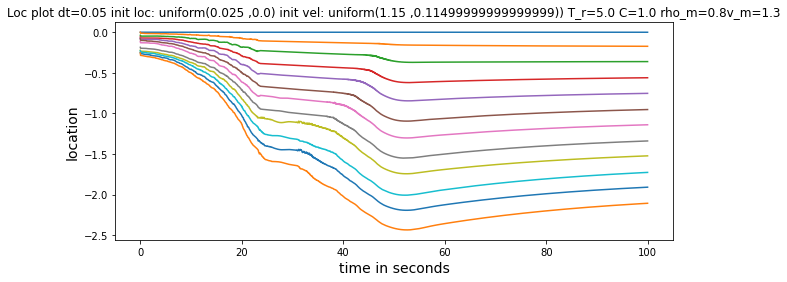

In [114]:
plt.figure(figsize=(10,4))
time = np.arange(int(round(traj_len/delta_gen)))*delta_gen
for i in range(n_cars):
    plt.plot(time,loc_matrix[i,:])
# plt.ylim(-400,20)
plt.title('Loc plot dt=' + str(delta_gen) + ' init loc: '+ loc_init + "(" + str(separation_mean) + ' ,' + str(round(separation_var,3)) +
          ') init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          ") T_r=" + str(T_r)+ " C=" + str(C)+ " rho_m=" +str(rho_max) +"v_m=" +str(v_max))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('location', fontsize=14)
plt.show()

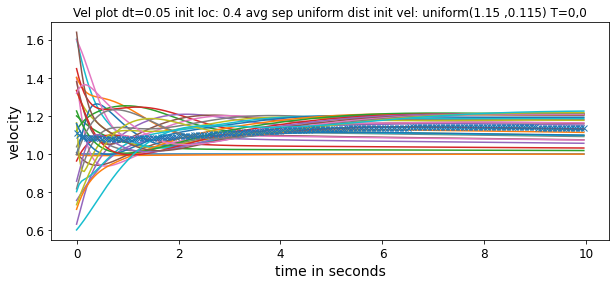

In [115]:
plt.figure(figsize=(10,4))
for i in range(n_cars):
    plt.plot(time,vel_matrix[i,:])
plt.plot(time,np.mean(vel_matrix,axis=0),'x',label='mean')
plt.title('Vel plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
          ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(round(vel_init_var,3)) + ")"+
          " T=" + str(T1) + "," +str(T2))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('velocity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0,6)
# plt.xlim(280,300)
# plt.legend()
plt.show()

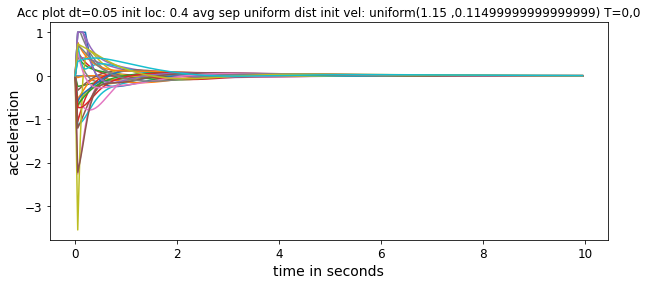

In [116]:
plt.figure(figsize=(10,4))
for i in range(n_cars):
    plt.plot(time,acc_matrix[i,:])
# plt.plot(time,np.mean(acc_matrix,axis=0),'x',label='mean')
plt.title('Acc plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
          ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          " T=" + str(T1) + "," +str(T2))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('acceleration', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend()
plt.show()